## Twitter Sentiment Analysis

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import re, string
import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
from nltk.corpus import stopwords
from  nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

from transformers import BertTokenizerFast, TFBertModel, RobertaTokenizerFast, TFRobertaModel

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as Layers
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

Build confusion matrix

In [5]:
def build_confusion_matrix(y, y_pred, title, labels):
    fig, ax =plt.subplots(figsize=(6,6))
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='g', cbar=False)
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17, rotation=90)
    ax.yaxis.set_ticklabels(labels, fontsize=17, rotation=0)
    plt.show()

Accuracy plot

In [144]:
def build_accurucay_plot(data, cols, title):
    plt.figure(figsize=(14, 6))
    model_output = pd.DataFrame(data)
    model_output[cols].plot()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.show()

### Loading the data

In [4]:
train_df = pd.read_csv('../dataset/Corona_NLP_train.csv',encoding='latin-1')
test_df = pd.read_csv('../dataset/Corona_NLP_test.csv', encoding='latin-1')

In [5]:
train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


### Pre-processing

Convert the date column 'TweetAt' to pandas datetime format

In [9]:
train_df['TweetAt'] = pd.to_datetime(train_df['TweetAt'])

Check for null/na values

In [10]:
print(train_df.shape)
train_df.isna().sum()

(41157, 6)


UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [11]:
print(test_df.shape)
test_df.isna().sum()

(3798, 6)


UserName           0
ScreenName         0
Location         834
TweetAt            0
OriginalTweet      0
Sentiment          0
dtype: int64

Replace NA values with "unknown location"

In [12]:
train_df["Location"].fillna("unknown location", inplace=True)
train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,2020-03-16,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,unknown location,2020-03-16,My food stock is not the only one which is emp...,Positive
4,3803,48755,unknown location,2020-03-16,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [13]:
test_df["Location"].fillna("unknown location", inplace=True)
test_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,unknown location,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


Check for duplicate tweets

In [14]:
train_df['OriginalTweet'].duplicated().sum()

0

In [15]:
test_df['OriginalTweet'].duplicated().sum()

0

### EDA

Number of tweeets per day

In [16]:
tweets_per_day = train_df['TweetAt'].dt.strftime('%m-%d-%y').value_counts().sort_index().reset_index(name='counts')

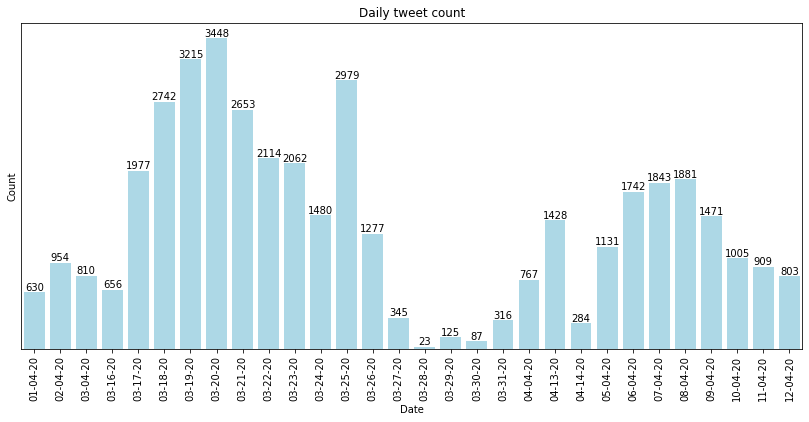

In [17]:
plt.figure(figsize=(14, 6))
ax = sns.barplot(x='index', y='counts', data=tweets_per_day, facecolor='lightblue')
plt.title('Daily tweet count')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('Count')
plt.xlabel('Date')
plt.xticks(rotation='vertical')
plt.show()

Tweets by location (top 20)

In [18]:
tweets_by_location = train_df[train_df['Location'] != 'unknown location']
tweets_by_location = tweets_by_location['Location'].value_counts().reset_index(name='counts')[:20]

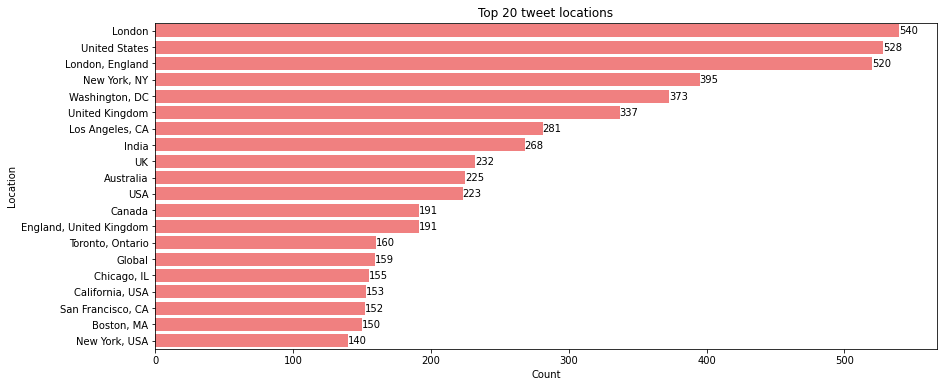

In [19]:
plt.figure(figsize=(14,6))
ax = sns.barplot(x='counts', y='index', data=tweets_by_location,facecolor = 'lightcoral')
plt.title('Top 20 tweet locations')
ax.bar_label(ax.containers[0])
plt.ylabel('Location')
plt.xlabel('Count')
plt.show()

Sentiment Counts

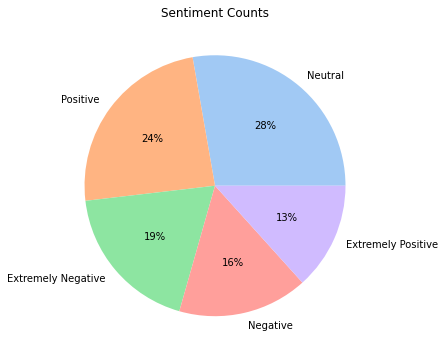

In [20]:
sentiment = train_df["Sentiment"].value_counts()
fig = plt.figure(figsize=(14,6))
fig.patch.set_facecolor('white')
plt.title('Sentiment Counts')
colors = sns.color_palette('pastel')[0:5]
ax = plt.pie(sentiment.values, labels = train_df["Sentiment"].unique(), colors = colors, autopct='%.0f%%')
plt.show()

Sentiments encoding to numerical values

In [39]:
target_mapping = {'Extremely Negative': 0, 'Negative': 1, 'Neutral': 2, 'Positive': 3, 'Extremely Positive': 4}

train_df['MappedSentiment'] = train_df['Sentiment'].map(lambda x: target_mapping[x])
test_df['MappedSentiment'] = test_df['Sentiment'].map(lambda x: target_mapping[x])

train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,MappedSentiment,MappedSentiment_3,CleanedTweet
0,3799,48751,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,2,0,menyrbi philgahan chrisitv
1,3800,48752,UK,2020-03-16,advice Talk to your neighbours family to excha...,Positive,3,1,advic talk neighbour famili exchang phone numb...
2,3801,48753,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,Positive,3,1,coronaviru australia woolworth give elderli di...
3,3802,48754,unknown location,2020-03-16,My food stock is not the only one which is emp...,Positive,3,1,food stock one empti pleas dont panic enough f...
4,3803,48755,unknown location,2020-03-16,"Me, ready to go at supermarket during the #COV...",Extremely Negative,0,-1,readi go supermarket covid19 outbreak im paran...


Sentiments encoding to numerical values (3 classes)

In [40]:
target_mapping = {'Extremely Negative': 0, 'Negative': 0, 'Neutral': 1, 'Positive': 2, 'Extremely Positive': 2}

train_df['MappedSentiment_3'] = train_df['Sentiment'].map(lambda x: target_mapping[x])
test_df['MappedSentiment_3'] = test_df['Sentiment'].map(lambda x: target_mapping[x])

train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,MappedSentiment,MappedSentiment_3,CleanedTweet
0,3799,48751,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,2,1,menyrbi philgahan chrisitv
1,3800,48752,UK,2020-03-16,advice Talk to your neighbours family to excha...,Positive,3,2,advic talk neighbour famili exchang phone numb...
2,3801,48753,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,Positive,3,2,coronaviru australia woolworth give elderli di...
3,3802,48754,unknown location,2020-03-16,My food stock is not the only one which is emp...,Positive,3,2,food stock one empti pleas dont panic enough f...
4,3803,48755,unknown location,2020-03-16,"Me, ready to go at supermarket during the #COV...",Extremely Negative,0,0,readi go supermarket covid19 outbreak im paran...


In [251]:
extremely_positive = train_df.loc[np.where(train_df['MappedSentiment'] == 4)].reset_index()
positive = train_df.loc[np.where(train_df['MappedSentiment'] == 3)].reset_index()
neutral = train_df.loc[np.where(train_df['MappedSentiment'] == 2)].reset_index()
negative = train_df.loc[np.where(train_df['MappedSentiment'] == 1)].reset_index()
extremely_negative = train_df.loc[np.where(train_df['MappedSentiment'] == 0)].reset_index()

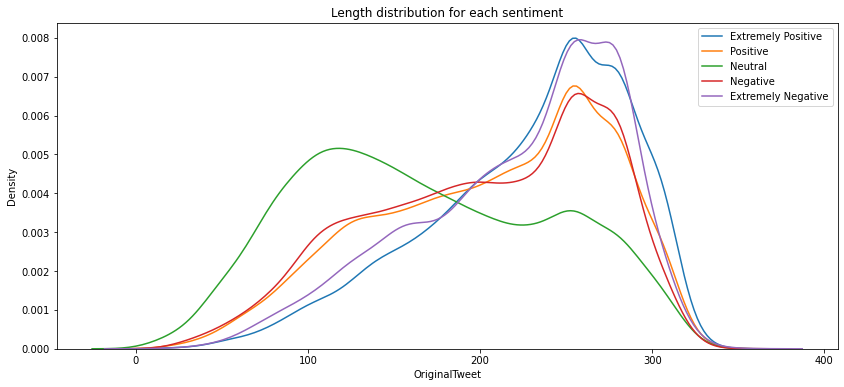

In [260]:
# hist_data = [extremely_positive['Length'],positive['Length'],neutral['Length'],
#              negative['Length'],extremely_negative['Length']]
group_labels = ['Extremely Positive','Positive','Neutral','Negative','Extremely Negative']
ex_pos = extremely_positive['OriginalTweet'].apply(len)
pos = positive['OriginalTweet'].apply(len)
neu = neutral['OriginalTweet'].apply(len)
neg = negative['OriginalTweet'].apply(len)
ex_neg = extremely_negative['OriginalTweet'].apply(len)

colors = sns.color_palette("muted")

plt.figure(figsize=(14,6))
sns.distplot(ex_pos, hist=False, rug=False, label=group_labels[0])
sns.distplot(pos, hist=False, rug=False, label=group_labels[1])
sns.distplot(neu, hist=False, rug=False, label=group_labels[2])
sns.distplot(neg, hist=False, rug=False, label=group_labels[3])
sns.distplot(ex_neg, hist=False, rug=False, label=group_labels[4])

plt.legend()
plt.title('Length distribution for each sentiment')
plt.show()

Text Cleaning

In [92]:
def tolowercase(tweet):
    return tweet.lower()

def remove_urls(tweet):
    tweet = re.sub(r"http\S+", " ", tweet)
    tweet = re.sub(r"www.\S+", " ", tweet)
    return tweet

def remove_hashtags(tweet):
    return re.sub(r"#"," ", tweet)

def remove_punctuations(tweet):
    return "".join(
        [char for char in tweet if char not in string.punctuation])

def remove_stopwords(tweet):
    stopword = stopwords.words('english')
    return " ".join([word for word in re.split('\W+', tweet)
                               if word not in stopword])

def stemmer(tweet):
    return " ".join([PorterStemmer().stem(word) for word in re.split('\W+', tweet)])

def clean_tweet(tweet):
    tweet_cleaned = tolowercase(tweet)
    tweet_cleaned = remove_urls(tweet_cleaned)
    tweet_cleaned = remove_hashtags(tweet_cleaned)
    tweet_cleaned = remove_punctuations(tweet_cleaned)
    tweet_cleaned = remove_stopwords(tweet_cleaned)
    tweet_cleaned = stemmer(tweet_cleaned)

    tweet_tokens = word_tokenize(tweet_cleaned)

    return tweet_cleaned

In [93]:
train_corpus = train_df['OriginalTweet'].apply(clean_tweet)
train_df['CleanedTweet'] = train_corpus
train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,MappedSentiment,MappedSentiment_3,CleanedTweet
0,3799,48751,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,2,1,menyrbi philgahan chrisitv
1,3800,48752,UK,2020-03-16,advice Talk to your neighbours family to excha...,Positive,3,2,advic talk neighbour famili exchang phone numb...
2,3801,48753,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,Positive,3,2,coronaviru australia woolworth give elderli di...
3,3802,48754,unknown location,2020-03-16,My food stock is not the only one which is emp...,Positive,3,2,food stock one empti pleas dont panic enough f...
4,3803,48755,unknown location,2020-03-16,"Me, ready to go at supermarket during the #COV...",Extremely Negative,0,0,readi go supermarket covid19 outbreak im paran...


In [94]:
test_corpus = test_df['OriginalTweet'].apply(clean_tweet)
test_df['CleanedTweet'] = test_corpus
test_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,MappedSentiment,MappedSentiment_3,CleanedTweet
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,0,0,trend new yorker encount empti supermarket she...
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive,3,2,couldnt find hand sanit fred meyer turn amazon...
2,3,44955,unknown location,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive,4,2,find protect love one coronaviru
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative,1,0,panic buy hit newyork citi anxiou shopper sto...
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,2,1,toiletpap dunnypap coronaviru coronavirusaust...


Word Ckoud

In [95]:
# Positive WordCloud
pos_df = train_df[train_df['MappedSentiment_3'] == 2]
pos_text = pos_df['CleanedTweet'].to_string(index = False)
pos_text = re.sub(r'\n','',pos_text)
pos_cloud = WordCloud(colormap = 'Greens').generate(pos_text)

# Neutral WordCloud
neut_df = train_df[train_df['MappedSentiment_3'] == 1]
neut_text = neut_df['CleanedTweet'].to_string(index = False)
neut_text = re.sub(r'\n','', neut_text)
neut_cloud = WordCloud(colormap = 'Blues').generate(neut_text)

# Negative wordcloud
neg_df = train_df[train_df['MappedSentiment_3'] == 0]
neg_text = neg_df['CleanedTweet'].to_string(index = False)
neg_text = re.sub(r'\n','', neg_text)
neg_cloud = WordCloud(colormap = 'Reds').generate(neg_text)

(-0.5, 399.5, 199.5, -0.5)

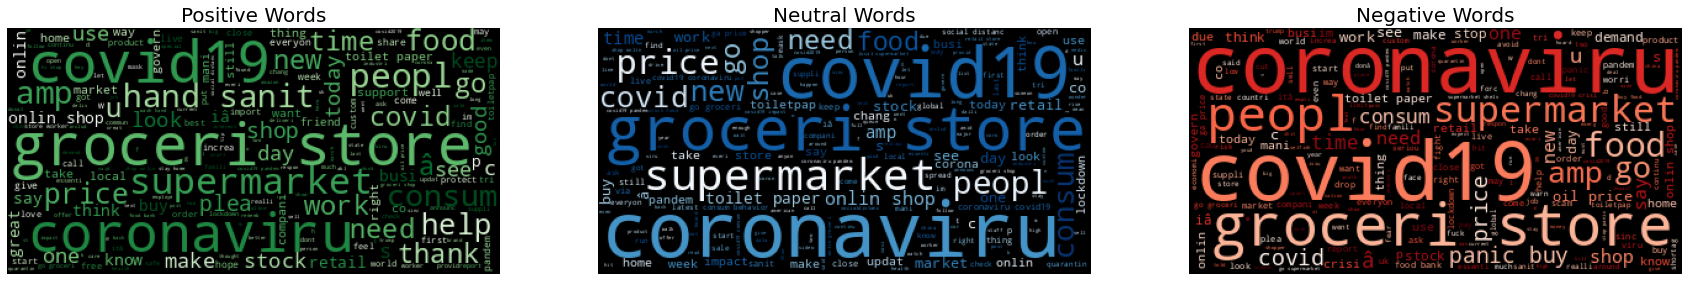

In [96]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = [30,20])
ax1.imshow(pos_cloud)
ax1.set_title('Positive Words', fontsize = 20)
ax1.axis('off')
ax2.imshow(neut_cloud)
ax2.set_title('Neutral Words', fontsize = 20)
ax2.axis('off')
ax3.imshow(neg_cloud)
ax3.set_title('Negative Words', fontsize = 20)
ax3.axis('off')

### Naive Bayes

In [97]:
sentiments = ['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive']
sentiments_3 = ['Negative', 'Neutral', 'Positive']

In [98]:
ros = RandomOverSampler()
X_train_os, y_train_os = ros.fit_resample(np.array(train_df['CleanedTweet']).reshape(-1, 1), np.array(train_df['MappedSentiment']).reshape(-1, 1));
train_os_5 = pd.DataFrame(list(zip([x[0] for x in X_train_os], y_train_os)), columns = ['CleanedTweet', 'MappedSentiment']);

In [99]:
train_os_5['MappedSentiment'].value_counts()

2    11422
3    11422
0    11422
1    11422
4    11422
Name: MappedSentiment, dtype: int64

In [100]:
X_train_nb_5 = train_os_5['CleanedTweet']
y_train_nb_5 = train_os_5['MappedSentiment']

X_test_nb_5 = test_df['CleanedTweet']
y_test_nb_5 = test_df['MappedSentiment']

In [101]:
ros = RandomOverSampler()
X_train_os, y_train_os = ros.fit_resample(np.array(train_df['CleanedTweet']).reshape(-1, 1), np.array(train_df['MappedSentiment_3']).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in X_train_os], y_train_os)), columns = ['CleanedTweet', 'MappedSentiment']);

In [102]:
train_os['MappedSentiment'].value_counts()

1    18046
2    18046
0    18046
Name: MappedSentiment, dtype: int64

In [103]:
X_train_nb = train_os['CleanedTweet']
y_train_nb = train_os['MappedSentiment']

X_test_nb = test_df['CleanedTweet']
y_test_nb = test_df['MappedSentiment_3']

### NB with 5 classes

Vectorize

In [104]:
count_vec = CountVectorizer()
X_train_vec =  count_vec.fit_transform(X_train_nb_5)
X_test_vec = count_vec.transform(X_test_nb_5)

TF-IDF

In [105]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_vec)
X_train_tf = tf_transformer.transform(X_train_vec)
X_test_tf = tf_transformer.transform(X_test_vec)

In [106]:
naive_bayes = MultinomialNB()

In [107]:
naive_bayes.fit(X_train_tf, y_train_nb_5)
test_preds_5 = naive_bayes.predict(X_test_tf)

In [108]:
print('\tClassification Report for Naive Bayes (5 classes):\n\n',classification_report(y_test_nb_5,test_preds_5, target_names=sentiments))

	Classification Report for Naive Bayes (5 classes):

                     precision    recall  f1-score   support

Extremely Negative       0.37      0.72      0.49       592
          Negative       0.45      0.31      0.37      1041
           Neutral       0.59      0.35      0.44       619
          Positive       0.44      0.28      0.35       947
Extremely Positive       0.45      0.70      0.55       599

          accuracy                           0.44      3798
         macro avg       0.46      0.47      0.44      3798
      weighted avg       0.46      0.44      0.42      3798



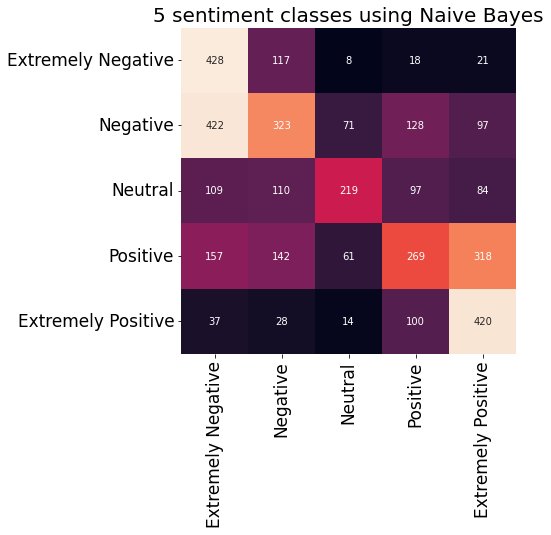

In [109]:
build_confusion_matrix(y_test_nb_5,test_preds_5,"5 sentiment classes using Naive Bayes", sentiments)

### NB with 3 classes

In [110]:
count_vec = CountVectorizer()
X_train_vec =  count_vec.fit_transform(X_train_nb)
X_test_vec = count_vec.transform(X_test_nb)

In [111]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_vec)
X_train_tf = tf_transformer.transform(X_train_vec)
X_test_tf = tf_transformer.transform(X_test_vec)

In [112]:
naive_bayes = MultinomialNB()

In [113]:
naive_bayes.fit(X_train_tf, y_train_nb)
test_preds_3 = naive_bayes.predict(X_test_tf)

In [293]:
f1_score(y_test_nb, test_preds_3, average='weighted')

0.6844550399343927

In [114]:
print('\tClassification Report for Naive Bayes (3 classes):\n\n',classification_report(y_test_nb,test_preds_3, target_names=sentiments_3))

	Classification Report for Naive Bayes (3 classes):

               precision    recall  f1-score   support

    Negative       0.70      0.78      0.74      1633
     Neutral       0.55      0.43      0.49       619
    Positive       0.72      0.69      0.71      1546

    accuracy                           0.69      3798
   macro avg       0.66      0.64      0.64      3798
weighted avg       0.68      0.69      0.68      3798



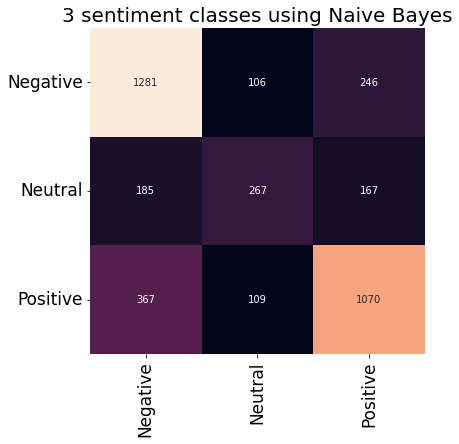

In [115]:
build_confusion_matrix(y_test_nb,test_preds_3,"3 sentiment classes using Naive Bayes", sentiments_3)

### RNN

In [116]:
X_train_rnn = train_os['CleanedTweet'].apply(clean_tweet)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_rnn)

X_rnn = tokenizer.texts_to_sequences(X_train_rnn)

vocab_size = len(tokenizer.word_index)+1

X_rnn = pad_sequences(X_rnn, padding='post')

In [118]:
y_train = train_os['MappedSentiment']
y_test = test_df['MappedSentiment_3']

In [131]:
X_rnn = tf.constant(X_rnn.astype('float32'))

In [151]:
tf.keras.backend.clear_session()

# hyper parameters
EPOCHS = 2
BATCH_SIZE = 32
embedding_dim = 16
units = 256

model = tf.keras.Sequential([
    Layers.Embedding(vocab_size, embedding_dim, input_length=X_rnn.shape[1]),
    Layers.Bidirectional(Layers.LSTM(units,return_sequences=True)),
    Layers.GlobalMaxPool1D(),
    Layers.Dropout(0.4),
    Layers.Dense(32, activation="relu"),
    Layers.Dropout(0.4),
    Layers.Dense(3)
])


model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',metrics=['accuracy']
             )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 49, 16)            815952    
_________________________________________________________________
bidirectional (Bidirectional (None, 49, 512)           559104    
_________________________________________________________________
global_max_pooling1d (Global (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                16416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 9

In [152]:
history = model.fit(X_rnn, y_train, epochs=2, validation_split=0.2, batch_size=BATCH_SIZE)

Epoch 1/2
1354/1354 [==============================] - 18s 11ms/step - loss: 0.6854 - accuracy: 0.7036 - val_loss: 0.6027 - val_accuracy: 0.7860
Epoch 2/2
1354/1354 [==============================] - 15s 11ms/step - loss: 0.4231 - accuracy: 0.8611 - val_loss: 0.5770 - val_accuracy: 0.7808


<Figure size 1008x432 with 0 Axes>

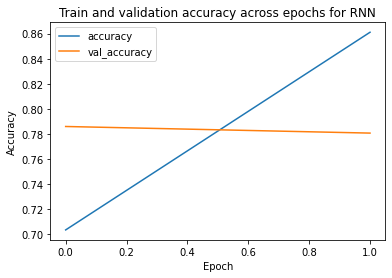

In [153]:
cols = ['accuracy', 'val_accuracy']
data = history.history
title = 'Train and validation accuracy across epochs for RNN'

build_accurucay_plot(data, cols, title)

<Figure size 1008x432 with 0 Axes>

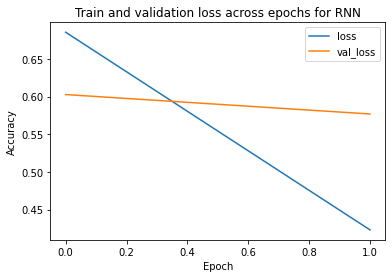

In [154]:
cols = ['loss', 'val_loss']
title = 'Train and validation loss across epochs for RNN'

build_accurucay_plot(data, cols, title)

In [155]:
X_test = test_df['CleanedTweet'].copy()
y_test = test_df['MappedSentiment_3'].copy()

X_test = X_test.apply(clean_tweet)

X_test = tokenizer.texts_to_sequences(X_test)

X_test = pad_sequences(X_test, padding='post')

In [157]:
rnn_pred = model.predict(X_test)
rnn_pred=np.argmax(rnn_pred, axis=1)

In [158]:
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

Test loss: 0.507453978061676
Test Accuracy: 0.815429151058197


In [295]:
f1_score(y_test, rnn_pred, average='weighted')

0.8143399282115269

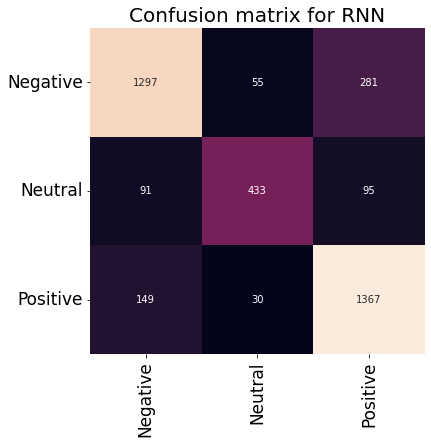

In [159]:
build_confusion_matrix(y_test, rnn_pred, 'Confusion matrix for RNN', sentiments_3)

BERT

In [196]:
train_bert_df = train_os.copy()
test_bert_df = test_df.copy()

In [197]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [198]:
token_lens = []

for tweet in train_bert_df['CleanedTweet'].values:
    tokens = tokenizer.encode(tweet, max_length=256, truncation=True)
    token_lens.append(len(tokens))
    
max_len=np.max(token_lens)

In [199]:
print("Max length of tokenized sentence:", max_len)

Max length of tokenized sentence: 106


In [200]:
train_bert_df['token_lens'] = token_lens

In [201]:
train_bert_df = train_bert_df.sort_values(by='token_lens', ascending=False)

In [202]:
train_bert_df.reset_index(drop=True, inplace=True)

In [203]:
token_lens_test = []

for tweet in test_bert_df['CleanedTweet'].values:
    tokens = tokenizer.encode(tweet, max_length=256, truncation=True)
    token_lens_test.append(len(tokens))
    
max_len=np.max(token_lens_test)

In [204]:
print("Max length of tokenized sentence for test df:", max_len)

Max length of tokenized sentence for test df: 90


In [205]:
test_bert_df['token_lens'] = token_lens_test

In [206]:
test_bert_df.reset_index(drop=True, inplace=True)

Train - Validation split

In [207]:
X = train_bert_df['CleanedTweet']
y = train_bert_df['MappedSentiment']

In [208]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [209]:
X_test = test_bert_df['CleanedTweet']
y_test = test_bert_df['MappedSentiment_3']

One-hot encoding the sentiment variable

In [210]:
ohe = OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [211]:
def tokenize(data, max_len=128) :
    input_ids = []
    attention_masks = []
    for tweet in data:
        encoded = tokenizer.encode_plus(
            tweet,
            max_length=128,
            padding='max_length',
            add_special_tokens=True,
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids),np.array(attention_masks)

In [219]:
X_train.reset_index(drop=True, inplace=True)
X_valid.reset_index(drop=True, inplace=True)

In [221]:
train_input_ids, train_attention_masks = tokenize(X_train)
val_input_ids, val_attention_masks = tokenize(X_valid)
test_input_ids, test_attention_masks = tokenize(X_test)

In [222]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [223]:
def build_bert_model(bert_model, max_len=128):
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-7)
    accuracy = tf.keras.metrics.CategoricalAccuracy()
    loss = tf.keras.losses.CategoricalCrossentropy()

    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    embeddings = bert_model([input_ids,attention_masks])[1]
    output = tf.keras.layers.Dense(3, activation="softmax")(embeddings)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)
    model.compile(optimizer, metrics=accuracy, loss=loss)
    
    return model

In [224]:
model = build_bert_model(bert_model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 3)            2307        tf_bert_model[0][1]          

In [225]:
history_bert = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=2, batch_size=32)

Epoch 1/2
1354/1354 [==============================] - 710s 514ms/step - loss: 0.6692 - categorical_accuracy: 0.7278 - val_loss: 0.5273 - val_categorical_accuracy: 0.8079
Epoch 2/2
1354/1354 [==============================] - 692s 511ms/step - loss: 0.4488 - categorical_accuracy: 0.8377 - val_loss: 0.4403 - val_categorical_accuracy: 0.8452


In [227]:
bert_results = model.predict([test_input_ids,test_attention_masks])

In [229]:
y_pred_bert =  np.zeros_like(bert_results)
y_pred_bert[np.arange(len(y_pred_bert)), bert_results.argmax(1)] = 1

In [232]:
loss, acc = model.evaluate([test_input_ids, test_attention_masks], y_test, verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

Test loss: 0.5511899590492249
Test Accuracy: 0.8009478449821472


<Figure size 1008x432 with 0 Axes>

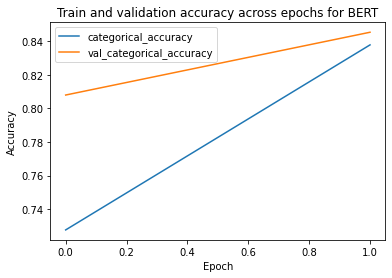

In [234]:
cols = ['categorical_accuracy', 'val_categorical_accuracy']
data = history_bert.history
title = 'Train and validation accuracy across epochs for BERT'

build_accurucay_plot(data, cols, title)

<Figure size 1008x432 with 0 Axes>

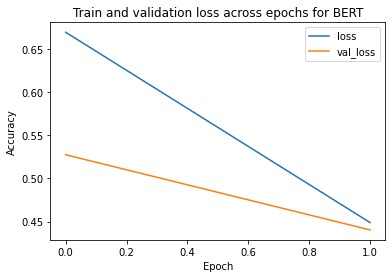

In [235]:
cols = ['loss', 'val_loss']
data = history_bert.history
title = 'Train and validation loss across epochs for BERT'

build_accurucay_plot(data, cols, title)

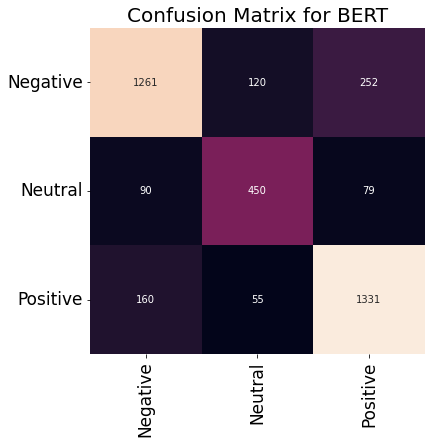

In [237]:
build_confusion_matrix(y_test.argmax(1), y_pred_bert.argmax(1),'Confusion Matrix for BERT', sentiments_3)

In [238]:
print('\tClassification Report for BERT:\n\n',classification_report(y_test,y_pred_bert, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for BERT:

               precision    recall  f1-score   support

    Negative       0.83      0.77      0.80      1633
     Neutral       0.72      0.73      0.72       619
    Positive       0.80      0.86      0.83      1546

   micro avg       0.80      0.80      0.80      3798
   macro avg       0.79      0.79      0.79      3798
weighted avg       0.80      0.80      0.80      3798
 samples avg       0.80      0.80      0.80      3798



### RoBERTa

In [309]:
roberta_tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

In [310]:
token_lens = []

for tweet in X_train:
    tokens = roberta_tokenizer.encode(tweet, max_length=512, truncation=True)
    token_lens.append(len(tokens))

max_len_roberta = np.max(token_lens)
max_len_roberta

134

In [317]:
def roberta_tokenize(data,max_len=128):
    input_ids = []
    attention_masks = []
    for tweet in data:
        encoded = roberta_tokenizer.encode_plus(
            tweet,
            max_length=max_len,
            padding='max_length',
            add_special_tokens=True,
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids),np.array(attention_masks)

In [318]:
X_train.reset_index(drop=True, inplace=True)
X_valid.reset_index(drop=True, inplace=True)

In [319]:
train_input_ids, train_attention_masks = roberta_tokenize(X_train)
val_input_ids, val_attention_masks = roberta_tokenize(X_valid)
test_input_ids, test_attention_masks = roberta_tokenize(X_test)

In [320]:
def build_roberta_model(roberta_model, max_len=128):
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-7)
    accuracy = tf.keras.metrics.CategoricalAccuracy()
    loss = tf.keras.losses.CategoricalCrossentropy()

    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    output = roberta_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(3, activation=tf.nn.softmax)(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)
    model.compile(optimizer, metrics=accuracy, loss=loss)
    
    return model

In [321]:
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [322]:
model = build_roberta_model(roberta_model)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_roberta_model_6 (TFRobertaMo TFBaseModelOutputWit 124645632   input_11[0][0]                   
                                                                 input_12[0][0]                   
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 3)            2307        tf_roberta_model_6[0][1]   

In [ ]:
history_roberta = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=2, batch_size=32)

In [104]:
result_roberta = model.predict([test_input_ids,test_attention_masks])

In [105]:
y_pred_roberta =  np.zeros_like(result_roberta)
y_pred_roberta[np.arange(len(y_pred_roberta)), result_roberta.argmax(1)] = 1

In [ ]:
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

In [ ]:
cols = ['accuracy', 'val_accuracy']
data = history_roberta.history
title = 'Train and validation accuracy across epochs for RoBERTa'

build_accurucay_plot(data, cols, title)

In [ ]:
cols = ['loss', 'val_loss']
data = history_roberta.history
title = 'Train and validation loss across epochs for RoBERTa'

build_accurucay_plot(data, cols, title)

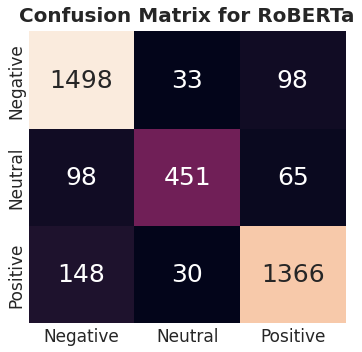

In [107]:
conf_matrix(y_test.argmax(1),y_pred_roberta.argmax(1),'Confusion Matrix for RoBERTa')

In [108]:
print('\tClassification Report for RoBERTa:\n\n',classification_report(y_test,y_pred_roberta, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for RoBERTa:

               precision    recall  f1-score   support

    Negative       0.86      0.92      0.89      1629
     Neutral       0.88      0.73      0.80       614
    Positive       0.89      0.88      0.89      1544

   micro avg       0.88      0.88      0.88      3787
   macro avg       0.88      0.85      0.86      3787
weighted avg       0.88      0.88      0.87      3787
 samples avg       0.88      0.88      0.88      3787

